# Confidence Intervals for a DistilBERT LLM

![](figures/finetuning-ii.png)

In [1]:
# pip install transformers

In [2]:
# pip install datasets

In [3]:
# pip install lightning

In [4]:
%load_ext watermark
%watermark --conda -p torch,transformers,datasets,lightning

torch       : 2.0.0
transformers: 4.27.4
datasets    : 2.11.0
lightning   : 2.0.1

conda environment: dl-fundamentals



### 1 Loading the dataset into DataFrames

In [5]:
# pip install datasets

import os.path as op

from datasets import load_dataset

import lightning as L
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint

import numpy as np
import pandas as pd
import torch

from sklearn.feature_extraction.text import CountVectorizer

from local_dataset_utilities import download_dataset, load_dataset_into_to_dataframe, partition_dataset
from local_dataset_utilities import IMDBDataset

In [6]:
download_dataset()

df = load_dataset_into_to_dataframe()
partition_dataset(df)

100% | 80.23 MB | 1.29 MB/s | 62.28 sec elapsed

100%|██████████████████████████████████████████████████████████████| 50000/50000 [00:29<00:00, 1721.93it/s]


Class distribution:


In [7]:
df_train = pd.read_csv("train.csv")
df_val = pd.read_csv("val.csv")
df_test = pd.read_csv("test.csv")

### 2 Tokenization and Numericalization

**Load the dataset via `load_dataset`**

In [8]:
imdb_dataset = load_dataset(
    "csv",
    data_files={
        "train": "train.csv",
        "validation": "val.csv",
        "test": "test.csv",
    },
)

print(imdb_dataset)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/sebastian/.cache/huggingface/datasets/csv/default-51afc85dfab42d63/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['index', 'text', 'label'],
        num_rows: 35000
    })
    validation: Dataset({
        features: ['index', 'text', 'label'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['index', 'text', 'label'],
        num_rows: 10000
    })
})


**Tokenize the dataset**

In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
print("Tokenizer input max length:", tokenizer.model_max_length)
print("Tokenizer vocabulary size:", tokenizer.vocab_size)

Tokenizer input max length: 512
Tokenizer vocabulary size: 30522


In [10]:
def tokenize_text(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)

In [11]:
imdb_tokenized = imdb_dataset.map(tokenize_text, batched=True, batch_size=None)

Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [12]:
del imdb_dataset

In [13]:
imdb_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [14]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### 3 Set Up DataLoaders

In [15]:
from torch.utils.data import DataLoader, Dataset


class IMDBDataset(Dataset):
    def __init__(self, dataset_dict, partition_key="train"):
        self.partition = dataset_dict[partition_key]

    def __getitem__(self, index):
        return self.partition[index]

    def __len__(self):
        return self.partition.num_rows

In [16]:
train_dataset = IMDBDataset(imdb_tokenized, partition_key="train")
val_dataset = IMDBDataset(imdb_tokenized, partition_key="validation")
test_dataset = IMDBDataset(imdb_tokenized, partition_key="test")

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=12,
    shuffle=True, 
    num_workers=4
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=12,
    num_workers=4
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=12,
    num_workers=4
)

### 4 Initializing DistilBERT

In [17]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

### 5 Finetuning

**Wrap in LightningModule for Training**

In [18]:
import lightning as L
import torch
import torchmetrics


class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate=5e-5):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)

    def forward(self, input_ids, attention_mask, labels):
        return self.model(input_ids, attention_mask=attention_mask, labels=labels)
        
    def training_step(self, batch, batch_idx):
        outputs = self(batch["input_ids"], attention_mask=batch["attention_mask"],
                       labels=batch["label"])        
        self.log("train_loss", outputs["loss"])
        return outputs["loss"]  # this is passed to the optimizer for training

    def validation_step(self, batch, batch_idx):
        outputs = self(batch["input_ids"], attention_mask=batch["attention_mask"],
                       labels=batch["label"])        
        self.log("val_loss", outputs["loss"], prog_bar=True)
        
        logits = outputs["logits"]
        predicted_labels = torch.argmax(logits, 1)
        self.val_acc(predicted_labels, batch["label"])
        self.log("val_acc", self.val_acc, prog_bar=True)
        
    def test_step(self, batch, batch_idx):
        outputs = self(batch["input_ids"], attention_mask=batch["attention_mask"],
                       labels=batch["label"])        
        
        logits = outputs["logits"]
        predicted_labels = torch.argmax(logits, 1)
        self.test_acc(predicted_labels, batch["label"])
        self.log("accuracy", self.test_acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    

lightning_model = LightningModel(model)

In [19]:
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger


callbacks = [
    ModelCheckpoint(
        save_top_k=1, mode="max", monitor="val_acc"
    )  # save top 1 model
]
logger = CSVLogger(save_dir="logs/", name="my-model")

In [20]:
trainer = L.Trainer(
    max_epochs=3,
    callbacks=callbacks,
    accelerator="gpu",
    precision="16-mixed",
    devices=[6],
    logger=logger,
    log_every_n_steps=10,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
import time

start = time.time()

trainer.fit(model=lightning_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

end = time.time()
print(f"Time elapsed: {(end-start)/60:.2f} min")

You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: logs/my-model
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name     | Type                                | Params
-----------------------------------------------------------------
0 | model    | DistilBertForSequenceClassification | 67.0 M
1 | val_acc  | MulticlassAccuracy                  | 0     
2 | test_acc | MulticlassAccuracy                  | 0     
-----------------------------------------------------------------
67.0 M    Trainable params
0         Non-trainable params
67.0 M    Total params
267.820   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


Time elapsed: 7.10 min


In [22]:
trainer.test(lightning_model, dataloaders=train_loader, ckpt_path="best")

You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/my-model/version_0/checkpoints/epoch=0-step=2917.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
Loaded model weights from the checkpoint at logs/my-model/version_0/checkpoints/epoch=0-step=2917.ckpt
/home/sebastian/miniforge3/envs/dl-fundamentals/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.9609143137931824     │
└───────────────────────────┴───────────────────────────┘

[{'accuracy': 0.9609143137931824}]

In [23]:
trainer.test(lightning_model, dataloaders=val_loader, ckpt_path="best")

You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/my-model/version_0/checkpoints/epoch=0-step=2917.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
Loaded model weights from the checkpoint at logs/my-model/version_0/checkpoints/epoch=0-step=2917.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │     0.923799991607666     │
└───────────────────────────┴───────────────────────────┘

[{'accuracy': 0.923799991607666}]

In [24]:
trainer.test(lightning_model, dataloaders=test_loader, ckpt_path="best")

You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/my-model/version_0/checkpoints/epoch=0-step=2917.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
Loaded model weights from the checkpoint at logs/my-model/version_0/checkpoints/epoch=0-step=2917.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │     0.917900025844574     │
└───────────────────────────┴───────────────────────────┘

[{'accuracy': 0.917900025844574}]

# Confidence Interval Methods

- Method 1: Normal Approximation Interval Based on a Test Set
- Method 2: Bootstrapping Training Sets
- Method 3: Bootstrapping the Test Set Predictions
- Method 4: Confidence Intervals from Retraining Models with Different Random Seeds

More details: 
- Creating Confidence Intervals for Machine Learning Classifiers: https://sebastianraschka.com/blog/2022/confidence-intervals-for-ml.html

- Sebastian Raschka (2018) *Model Evaluation, Model Selection, and Algorithm Selection in Machine Learning*, https://arxiv.org/abs/1811.12808

# Method 1: Normal Approximation Interval Based on a Test Set

- Among the easiest ways of creating confidence intervals 
- How? Compute the confidence interval from a single training-test split. 
- Why? 
  - Attractive in deep learning where model training is expensive. 
  - Attractive in deep learning when we are interested in a very particular model
    (vs. models fit on different training folds like in k-fold cross-validation).




## The Method in a Nutshell

For a parameter like the accuracy (assuming a normal distribution) we compute a confidence interval as follows:

$$\text{ACC}_{\text{test}} \pm z \times \text{SE}$$

- $z$: how many standard deviations the parameter lies from the mean of a standard normal distribution

- $\text{SE}$ is the standard error of the parameter (here: $\text{ACC}_{\text{test}}$)

In the context of a Binomial proportion confidence interval, we calculate the standard error as follows, where $n$ is the test set size:

$$\text{SE} = \sqrt{ \frac{1}{n} \text{ACC}_{\text{test}}\left(1- \text{ACC}_{\text{test}}\right)}$$

In [25]:
import scipy.stats

confidence = 0.95  # Change to your desired confidence level
z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)
print(z_value)

1.959963984540054


In [27]:
acc_test = 0.9179

In [31]:
n = len(test_dataset)

In [32]:
import numpy as np

ci_length = z_value * np.sqrt((acc_test * (1 - acc_test)) / n)

ci_lower = acc_test - ci_length
ci_upper = acc_test + ci_length

print(ci_lower, ci_upper)

0.9125195654289883 0.9232804345710118


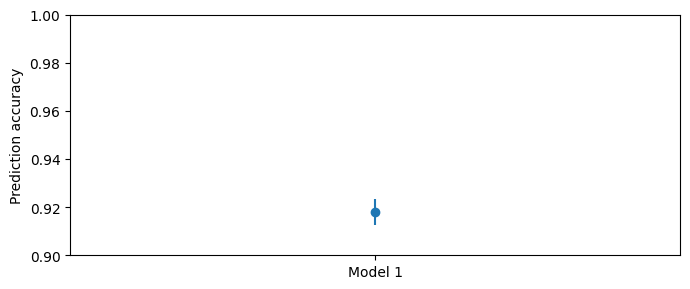

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 3))

ax.errorbar(0, acc_test, yerr=ci_length, fmt="o")

ax.set_ylim([0.9, 1.0])
ax.set_xticks(np.arange(1))
ax.set_xticklabels(["Model 1"])
ax.set_ylabel("Prediction accuracy")

plt.tight_layout()

plt.show()